# Particle Tracking Code - Demonstration using silica beads imaged under bright-field

We'll use the *widely* used particle tracking code that's based on code developed by [John Crocker](http://crocker.seas.upenn.edu/). Originally, that code was developed in IDL. But others have rewritten it in Matlab (for example, [here](http://site.physics.georgetown.edu/matlab/)) and in Python. We'll use the Python code which is provided by [Maria Kilfoil](http://people.umass.edu/kilfoil/). 

The Python particle tracking code we'll use was grabbed from [here](http://people.umass.edu/kilfoil/tools.php). But I've made some slight changes (necessary for how we'll load the images and given the updated version of Python we're using). 

First thing you'll need is a video of particles diffusing. Use the ~0.7 micron silica spheres. Below is an image from a video I took. 
![Image of beads](Silica700_2018-05-16.png)

Notice a couple things. Firstly, there may be a lot of dust and dirt on the optics that is giving us a nasty background. This isn't really the case here but that's because I've selected a small ROI (region-of-interest). Secondly, the particles appear **dark against a lighter background**. For this particle-tracking code, we'll need particles that appear brighter than the background. This is easily acheived with fluorescence imaging. For bright-field imaging this is not always the case (as we see here). When taking images on the microscope, pay attention to the kind of contrast in the image (bright particles on dark background or vice versa) when the focus is varied. An option you can use if your images show dark particles on a bright background is to invert the images using ImageJ. 

To deal with the first issue mentioned above (the nasty background) we'll first calculate the *median* of the image. This is done with [**ImageJ**](https://fiji.sc/). Go to Image -> Stacks -> Z-Project and in "Projection Type" select Median. Now, subtract that median from the other images using Process -> Image Calculator. Check the 32-bit result box. Then convert to 8-bit (Image -> Type) and save as a tiff file. You may elect to crop the image as well. If you need to invert the image in order to see bright beads on a dark background, then, in ImageJ, go Edit -> Invert. See the result of those operations here: ![Background-subtracted image](Silica700_2018-05-16_bgsub.png). 

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

#For making interactive user interfaces (buttons and sliders and such)
#import ipywidgets as widgets

#Loading the particle tracking software
import sys
sys.path.append("..\\track") #Locate code
import mpretrack #The file mpretrack.py and trackmem.py should be in the location above
import trackmem
import bpass
import tiff_file #Ignore any warnings importing this may cause

..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


#### You may need to edit the location of the data in the cell below

In [2]:
#Now let's locate the data
data_directory = "Z:\\Kathryn_2019\\LinearDNA_buffer\\2019-03-18_KathrynDNA\\03182019_1to2_LinearDNA_Kat_98exp_10fps_7\\" #Notice the double slashes!
data_file = "03182019_1to2_LinearDNA_Kat_98exp_10fps_7_MMStack_Pos0.ome.tif"

### Let's inspect the data

We'll show the first frame of the movie we'll use. 
Then we'll show what that frame looks like when we filter it using a bandpass filter.

Note that the first line in the cell below is <code>%matplotlib inline</code>. 
This produced figures that show up in this document. But if want separate windows to pop-up that show the figure, then you can use <code>%matplotlib qt5</code>. If you do that, you should create a new code cell above and just run that command. 

<IPython.core.display.Javascript object>


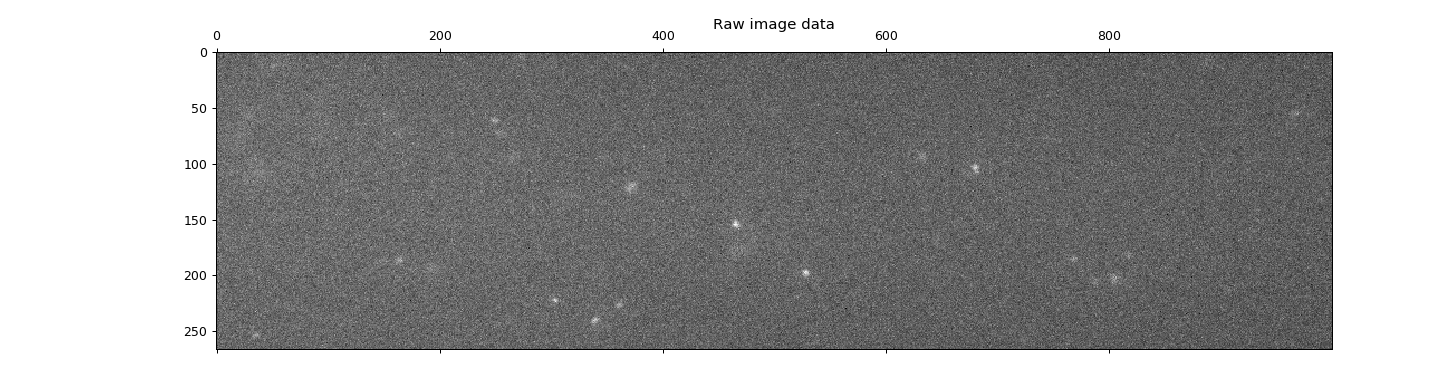

<IPython.core.display.Javascript object>


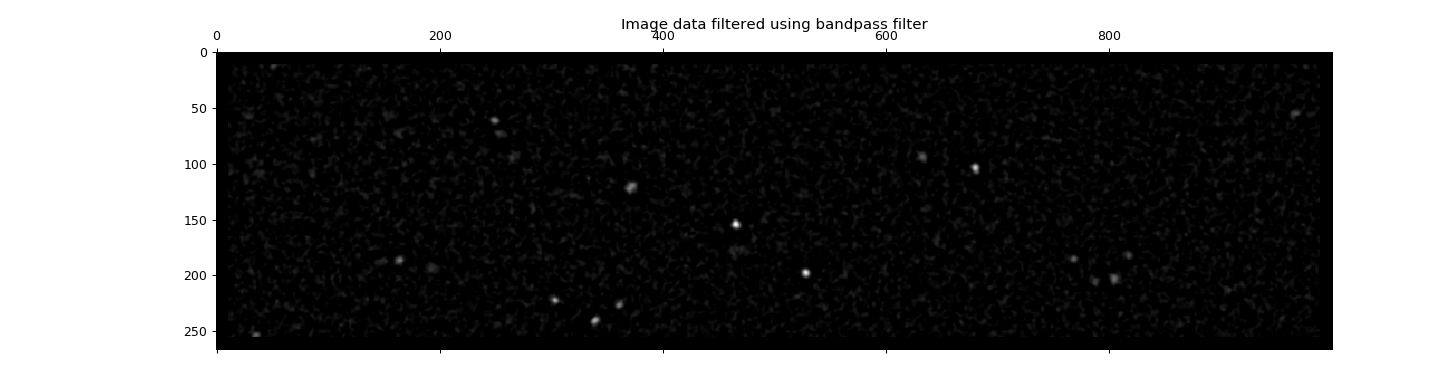

<IPython.core.display.Javascript object>


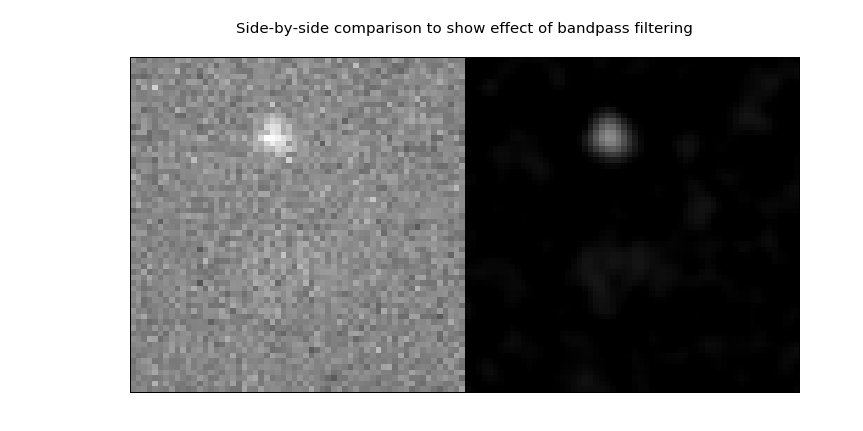

In [4]:
%matplotlib notebook

#We use the "tiff_file" module to deal with image data in tif formats.
#The function 'imread' reads in the image. We can either read in the whole entire
#  movie or just read in a specific frame. Here, we are reading in only the first 
#  frame. We do this by setting the optional paratmer 'key' equal to 0. 
frame1_image = tiff_file.imread(data_directory+data_file,key=0)

plt.matshow(frame1_image, cmap=matplotlib.cm.gray) #'cmap' is the colormap used
plt.title("Raw image data")

#Let's try filtering the data with a bandpass filter. This filter is used when
#  identifying features in the image. 
bpass_image = bpass.bpass(frame1_image,1,11)

plt.matshow(bpass_image, cmap=matplotlib.cm.gray)
plt.title("Image data filtered using bandpass filter")

#We'll show a side-by-side comparison of non-filtered and filtered images.
# Using the numpy function 'hstack' to combine two arrays horizontally
startx = 140
stopx = startx+60
starty = 440
stopy = 440+60
plt.matshow(np.hstack((frame1_image[startx:stopx, starty:stopy], bpass_image[startx:stopx, starty:stopy])), cmap=matplotlib.cm.gray, interpolation='nearest')
plt.xticks([]); plt.yticks([]) #This removes the labeling of the axes values
plt.title('Side-by-side comparison to show effect of bandpass filtering');


-----------TEST-----------
4 features found.
Intensity of 1st particle: 6474.40
Rg of 1st particle: 15.03
Eccentricity of 1st particle: 0.0847
[[6.79619372e+02 1.03955981e+02 6.47440495e+03 1.50280133e+01
  8.46631198e-02]
 [3.71505471e+02 1.20556426e+02 6.78708185e+03 1.64552339e+01
  1.23947324e-01]
 [4.65550029e+02 1.53904889e+02 7.24806639e+03 9.47706908e+00
  4.67624447e-02]
 [5.27983448e+02 1.97288694e+02 6.47317594e+03 1.09965647e+01
  4.11318051e-02]]


<IPython.core.display.Javascript object>


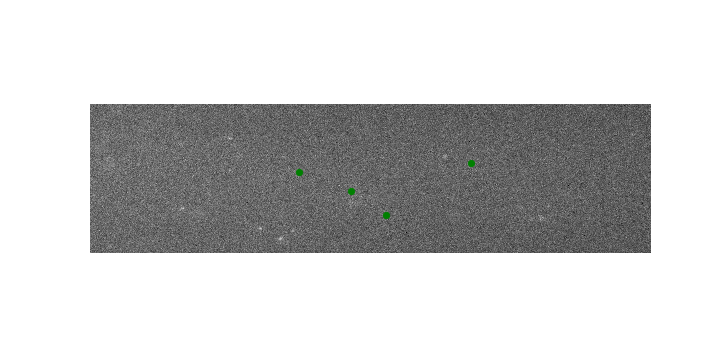

4 features kept.
Minimum Intensity : 6473.175936999195
Maximum Rg : 16.455233880221424
Maximum Eccentricity : 0.12394732358204173
--------------------------


In [27]:
#Use the function 'test' in mpretrack to find good set of parameters

###############################################################################
# Options from mpretrack:
#    barI: minimum integrated intensity
#    barRg: maximum radius of gyration squared (in pixel squared)
#    barCc: minimum eccentricity accepted
#    IdivRg: minimum ratio of of integrated intensity to radius of gyr sqrd
#    Imin: minimum intensity of local max -- set to 0 to use default "top 30%"
#    masscut: threshold for integrated intesnity of features before refinement
#    field: 2 for full frame (0 or 1 if interlaced video)
###############################################################################

frame_num = 0 #We'll use the first frame
feature_size = 11
%matplotlib notebook
mt, mrej = mpretrack.test(data_directory,data_file,frame_num,feature_size,
                          masscut = 6000, Imin=100, barI = 3900, barRg = 50,
                          barCc = None, IdivRg=1.0, verbose=True, bandpass='bp');

Did that look okay? You should see a figure appear with green dots where the program found particles. Red dots indicate that particles were identified but then discarded due to not meeting the thresholds (like being below the minimum integrated intensity or exceeding the maximum radius of gyration).

Now we'll run the feature-finding algorithm with the paramters we found on *all* frames.

In [28]:
num_frames = 500 #number of frames to find particles

#Same parameters used as in "test".
#NOTE: I set verbose=False here so it doesn't print out too much 
#But you should set verbose=True. 
#It will then print out how many particles found in each frame.
mt = mpretrack.run(data_directory,data_file,num_frames,feature_size,
                   masscut = 6000, Imin=100, barI = 3900, barRg = 50,
                   barCc = None, IdivRg=1.0, verbose=False, bandpass='bp')

Frame 0
Frame 50
Frame 100
Frame 150
Frame 200
Frame 250
Frame 300
Frame 350
Frame 400
Frame 450


In each frame, the code has identified particles (i.e., features). Now we have to link them together into "tracks."


In [30]:
### Tracking with fancytrack:
num_dimensions = 2 #We take 2-dimensional images
max_displacement = 19 #Maximum displacement between consecutive frames to count as same particle
goodenough = 6 #Minimum length for trajectory
memory = 0 #how many consecutive frames a feature is allowed to skip. 
tracks = trackmem.trackmem(mt, max_displacement, num_dimensions, goodenough, memory)

What's in <code>tracks</code>?
+ <code>tracks[:,0]</code> is the *x*-coordinate of particle (in terms of pixel)
+ <code>tracks[:,1]</code> is the *y*-coordinate
+ <code>tracks[:,2]</code> is the integrated brightness of found features
+ <code>tracks[:,3]</code> is the square of the radius of gyration
+ <code>tracks[:,4]</code> is the eccentricity (zero for circularly symmetric features)
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number

Let's look at how many trajectories we've found, what the length of some of these trajectories are and what they look like superimposed on an image of the beads.

In [31]:
#The last element in the each "track" is the track ID number. It starts at one. 
# So finding the maximum of the track ID number will tell us how many tracks
# there are. 
print "Number of trajectories: %i" % tracks[:,7].max()

Number of trajectories: 72


In [32]:
#Just to get a sense of the length of the trajectories.
#Printing the lenghts by funding all instances where the track ID
#  number is 1, 2, 3. 

print "Length of 1st trajectory: %i" % np.sum(tracks[:,7]==1)
if tracks[:,7].max()>1: #this checks to make sure there is a track ID 2
    print "Length of 2nd trajectory: %i" % np.sum(tracks[:,7]==2)
if tracks[:,7].max()>2:
    print "Length of 3rd trajectory: %i" % np.sum(tracks[:,7]==3)

Length of 1st trajectory: 20
Length of 2nd trajectory: 8
Length of 3rd trajectory: 12


Let's check for pixel biasing. By making a histogram of the mantissa of the positions (done using the [modulus function in numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mod.html)). 

Ideally, this histogram will look flat. That would indicate that finding a particle at *x* = 3.4 is just as likely as finding it at *x* = 3.0. 

If pixel biasing is occuring, you'll see that, for instance, a particle at *x* = 3.0 is more likely than at *x* = 3.5. If you see pixel biasing occuring, you may need to check the <code>feature_size</code> parameter in the tracking code. You can also check that the bandpass filter is being used.

<IPython.core.display.Javascript object>


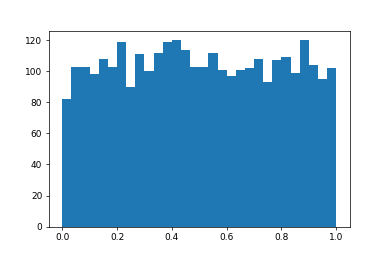

(array([ 82., 103., 103.,  98., 108., 103., 119.,  90., 111., 100., 112.,
        119., 120., 114., 103., 103., 112., 101.,  97., 101., 102., 108.,
         93., 107., 109.,  99., 120., 104.,  95., 102.]),
 array([2.78888449e-04, 3.35971784e-02, 6.69154683e-02, 1.00233758e-01,
        1.33552048e-01, 1.66870338e-01, 2.00188628e-01, 2.33506918e-01,
        2.66825208e-01, 3.00143498e-01, 3.33461788e-01, 3.66780078e-01,
        4.00098367e-01, 4.33416657e-01, 4.66734947e-01, 5.00053237e-01,
        5.33371527e-01, 5.66689817e-01, 6.00008107e-01, 6.33326397e-01,
        6.66644687e-01, 6.99962977e-01, 7.33281267e-01, 7.66599557e-01,
        7.99917847e-01, 8.33236136e-01, 8.66554426e-01, 8.99872716e-01,
        9.33191006e-01, 9.66509296e-01, 9.99827586e-01]),
 <a list of 30 Patch objects>)

In [33]:
%matplotlib notebook
plt.figure()
plt.hist(np.hstack((np.mod(tracks[:,0],1), np.mod(tracks[:,1],1))), bins=30) #plotting histogram

<IPython.core.display.Javascript object>


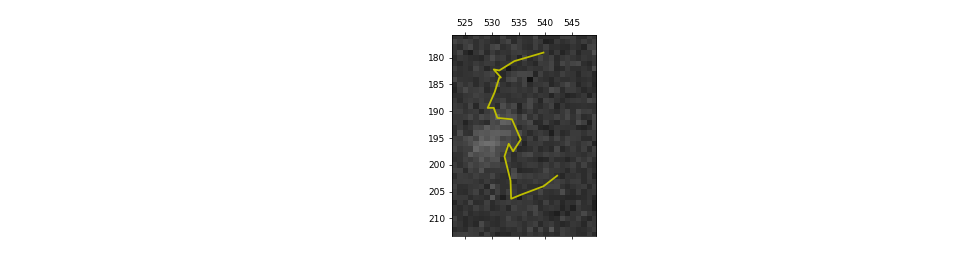

<IPython.core.display.Javascript object>


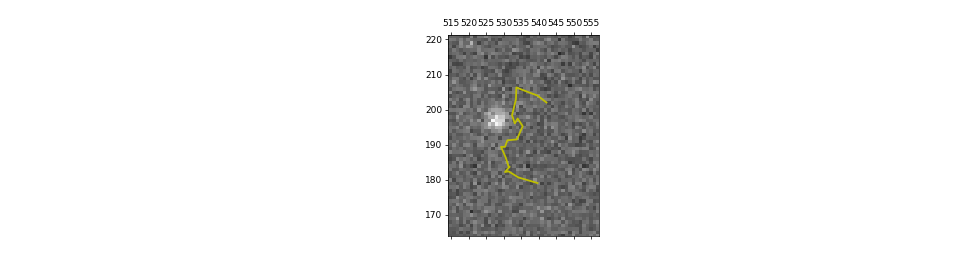

In [18]:
%matplotlib notebook

frame1_image = tiff_file.imread(data_directory+data_file,key=0) #read in first frame
frame2_image = tiff_file.imread(data_directory+data_file,key=1) #read in first frame
frame3_image = tiff_file.imread(data_directory+data_file,key=2) #read in first frame

#Sometimes images need to be flipped upside down. If that's the case, change False to True
if False:
    plt.matshow(np.flipud(frame1_image), cmap=matplotlib.cm.gray) #not sure why I need the flipud but seem to
else:
    plt.matshow(frame1_image + frame2_image + frame3_image, cmap=matplotlib.cm.gray)

#Locate track ID 37 (that's just one I found that looks okay)
w = np.where(tracks[:,7]==2)

plt.plot(tracks[w[0],0],tracks[w[0],1],'-y',lw=2) #drawing the trajectory with a yellow line

#Show same thing but zoom in on the track
if False:
    plt.matshow(np.flipud(frame1_image), cmap=matplotlib.cm.gray) #not sure why I need the flipud but seem to
else:
    plt.matshow(frame1_image, cmap=matplotlib.cm.gray)
plt.plot(tracks[w[0],0],tracks[w[0],1],'-y',lw=2)
plt.xlim(tracks[w[0],0].min()-15,tracks[w[0],0].max()+15); #Setting the x-limits for the figure. I'm zooming in on the bead in question
plt.ylim(tracks[w[0],1].min()-15,tracks[w[0],1].max()+15); #Setting y-limits

In [34]:
track_IDs_Length = np.zeros((int(tracks[:,7].max()),2)) #Array of track ID numbers and length of those tracks

#Here, we loop over every particle
for i in range(1,int(tracks[:,7].max()+1)):
    w = np.where(tracks[:,7]==i) #Find the locations in the matrix for given particle
    track_IDs_Length[i-1,0] = i
    track_IDs_Length[i-1,1] = len(w[0]) #This tells us the length of the particle's trajectory
    
total_sd = np.zeros((num_frames)) #total squared displacements
num_sd = np.zeros((num_frames)) #number of squared displacements
len_cutoff = 3 #we will require particles to be tracked for more than this length. otherwise, not included in msd calcs
for i in range(0,len(track_IDs_Length)):
    if track_IDs_Length[i,1]>len_cutoff:
        
        #Find indices for a given track ID number
        w = np.where(tracks[:,7]==track_IDs_Length[i,0])
        
        xys = tracks[w[0],0:2] #x- and y-positions
        
        #Loop over delay times
        for j in range(1,xys.shape[0]-1):
            xdiff = xys[j:,0]-xys[0:-1*(j),0] #Vector of displacment in x
            ydiff = xys[j:,1]-xys[0:-1*(j),1] #Vector of displacment in y
            squared_displacement = xdiff**2 + ydiff**2 #Squared displacemnt in x-y plane
            
            #Here, sum the squared displacments and keep track of how many
            # displacements when into the sum. This way we can find the average.
            total_sd[j-1] = total_sd[j-1] + squared_displacement.sum()
            num_sd[j-1] = num_sd[j-1] + len(squared_displacement)

In [35]:
%matplotlib notebook

<IPython.core.display.Javascript object>


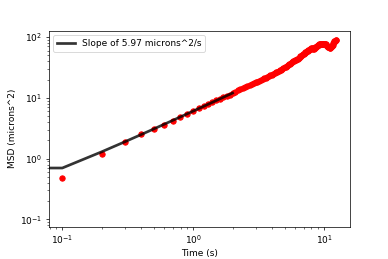

In [38]:
%matplotlib notebook

pixel_size = 0.194
# ------> You may need to adjust pixel size <----------
frame_rate = 10.03 #Frame rate used to acquire data
# ------> You may also need to adjust the framerate <-------

w = np.where(num_sd>0)
msd = (total_sd[w]/num_sd[w]) * (pixel_size**2)
times = np.arange(1,len(msd)+1)/frame_rate
time_cutoff = 2.0#For fitting to line, only look at msd less than this time interval
w = np.where(times<time_cutoff) #Find where time is less than time_cutoff


plt.loglog(times, msd,'ro') #Plot mean-squared displacement versus time with red filled circles
start_t =1
linear_fit = np.polyfit(times[w][start_t:], msd[w][start_t:],1) #fit to polynomial of order 1 (i.e., a line)
values_from_fit = np.polyval(linear_fit, np.hstack((np.array([0]),times[w]))) #evaluate polynomial
plt.plot(np.hstack((np.array([0]),times[w])), values_from_fit,
             '-k', lw=3, alpha=0.8, label = r"Slope of %.2f microns^2/s" % linear_fit[0])

plt.legend() #puts the 'label' on the plot
plt.xlabel('Time (s)');
plt.ylabel('MSD (microns^2)');
#plt.xlim(0,2.5)

In [39]:
print "Estimate of localization error: %.4f microns" % linear_fit[1]**0.5
print "Found diffusion coeff D = %.4f (microns^2/s)" % (0.25*linear_fit[0])

Estimate of localization error: 0.3270 microns
Found diffusion coeff D = 1.4926 (microns^2/s)


In [345]:
1.5*0.6

0.8999999999999999

In [209]:
#Some parameters...
kb = 1.38065e-23  #Boltzmann's constant
t = 294 #temperature in Kelvin
viscosity = 1.002e-3 # 1.002 mPa*s
radius = 380e-9
diffusion_coeff = (kb*t)/(6*np.pi*viscosity*radius)
est_radius = (kb*t)/(6*np.pi*viscosity*0.25*linear_fit[0]*1e-12)
print "Esimated radius (in nanometers): %.3f nm" % (est_radius*1e9)


Esimated radius (in nanometers): 131.401 nm
